# Plotting functions for macrophysical delays

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
import illustris_python.groupcat as gc
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import solve_ivp
import readtreeHDF5
import astropy.constants as const
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.ticker import FixedLocator, FuncFormatter
import matplotlib.font_manager

In [24]:
fpaths = matplotlib.font_manager.findSystemFonts()
plt.rc('font', family='Nimbus Roman', size = 9)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command
colour_map = sns.color_palette("husl", 8)

In [25]:
LITTLE_H = 0.679
VOLUME = (100/LITTLE_H)**3  # cMpc^3

## Delays only (no accretion)

In [26]:
indices = []
primary_mass = []
secondary_mass = []
time_delays = []
galaxies_merged = []
galaxy_separation = []
redshifts_galaxies = []
simulation_redshifts = []
halo_mass_at_numerical_merger = []
path = '../data/new_delay_data/'
files = os.listdir(path)
H0 = LITTLE_H * 100
Om0 = 0.3065
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
for file in files:
    with open(path + file, 'r') as f:
        for line in f:
            entries = line.strip().split()
            index_1 = int(entries[0])
            index_2 = int(entries[1])
            index = f'{index_1}_{index_2}'
            if index not in indices:
                indices.append(index)
                m1 = float(entries[2])
                m2 = float(entries[3])
                if m1 < m2:
                    primary_mass.append(m2)
                    secondary_mass.append(m1)
                else:
                    primary_mass.append(m1)
                    secondary_mass.append(m2)
                redshift_merger = float(entries[4])
                simulation_redshifts.append(redshift_merger)
                redshift_galaxies = float(entries[5])
                redshifts_galaxies.append(redshift_galaxies)
                galaxies_merged.append(entries[6] == 'True')
                galaxy_separation.append(float(entries[7])) # this is in kpc

                # calculate the time delay from the redshifts
                age_bh = cosmo.age(redshift_merger)
                age_galaxy = cosmo.age(redshift_galaxies)
                time_delay = (age_galaxy - age_bh).to(u.Gyr).value
                time_delays.append(time_delay)

print('The total number of major merger events is: ', len(indices))
zero_indices = [i for i, delay in enumerate(time_delays) if delay == 0]
print('Number of major mergers with no delay: ', len(zero_indices))
not_merged_indices = [i for i, merged in enumerate(galaxies_merged) if not merged]    
print('Number of mergers that do not merge by redshift 0: ', len(not_merged_indices))
time_delays_without_non_mergers = np.delete(time_delays, not_merged_indices)

The total number of major merger events is:  10709
Number of major mergers with no delay:  499
Number of mergers that do not merge by redshift 0:  3176


### Distribution of time delays

In [27]:
def generate_time_delay(delay_until_0, delay_distribution):
    """
    Generate a time delay from the distribution of time delays, given a minimum time delay.
    Used to predict the full time delay for mergers that don't merge by redshift 0.
    """
    number_of_valid_samples = 0
    counter = 0
    while number_of_valid_samples < 1:
        if delay_distribution(delay_until_0) < 1e-5: # if the probability of the delay is very low, assign this delay without any modification
            return delay_until_0, 1
        delay_samples = delay_distribution.resample(10000)[0]
        valid_samples = delay_samples[delay_samples > delay_until_0]
        number_of_valid_samples = len(valid_samples)
        if len(valid_samples) > 0:
            delay = np.random.choice(valid_samples)
            # print(delay)
            probability = delay_distribution(delay)[0]
            if probability < 1e-10:
                print(delay_distribution(delay))
            return delay, probability
        counter += 1

In [28]:
# generate artificial time delays

not_merged_indices = [i for i, merged in enumerate(galaxies_merged) if not merged]
time_delays_without_non_mergers = np.delete(time_delays, not_merged_indices)

delay_distribution = gaussian_kde(time_delays_without_non_mergers)

time_delays_artificial = []

probabilities = []
probabilities2 = []

for counter, i in enumerate(not_merged_indices):
    redshift_BH = simulation_redshifts[i]
    # Find the time between redshift_BH and redshift 0
    delay_until_0 = time_delays[i]
    delay, probability = generate_time_delay(delay_until_0, delay_distribution)
    time_delays_artificial.append(delay)
    probabilities.append(delay_distribution(delay)[0])
    probabilities2.append(probability)

print('The maximum time delay is: ', max(time_delays_artificial))

all_time_delays_artificial = np.append(time_delays_without_non_mergers, time_delays_artificial)

The maximum time delay is:  12.579636218916635


/tmp/ipykernel_1022771/2294971715.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels)


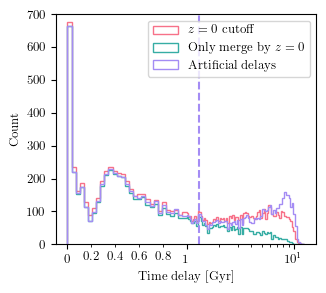

In [29]:
linear_bins = np.linspace(0, 1, 30)  # Linear bins from 0 to 1 Gyr
log_bins_positive = np.logspace(0, np.log10(max(time_delays)), 76)  # Logarithmic bins for values > 1 Gyr

# Combine the bins
bins = np.concatenate((linear_bins[:-1], log_bins_positive))

# plot the distribution of time delays
plt.figure(figsize=(10/3, 3))
plt.hist(time_delays, bins = bins, label=r'$z=0$ cutoff', histtype='step', density=False, color=colour_map[0])
plt.hist(time_delays_without_non_mergers, bins = bins, label='Only merge by $z=0$', histtype='step', density=False, color=colour_map[4])
plt.hist(all_time_delays_artificial, bins = bins, label='Artificial delays', histtype='step', density = False, color=colour_map[6])
plt.xlabel('Time delay [Gyr]')
plt.ylabel('Count')
plt.xscale('symlog',linthresh = 1)
plt.axvline(1.3, color = colour_map[6], linestyle = '--')

# Set minor ticks for linear and log regions
minor_ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.gca().xaxis.set_minor_locator(FixedLocator(minor_ticks))

def custom_minor_formatter(x, pos):
    if x in [0.2, 0.4, 0.6, 0.8]:  # Choose which minor ticks to label
        return f'{x}'
    else:
        return ''

plt.gca().xaxis.set_minor_formatter(FuncFormatter(custom_minor_formatter))

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
labels[1] = '1'

plt.gca().set_xticklabels(labels)
plt.ylim(0, 700)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/time_delays.png', dpi=600)

### Cumulative number of mergers as a function of redshift

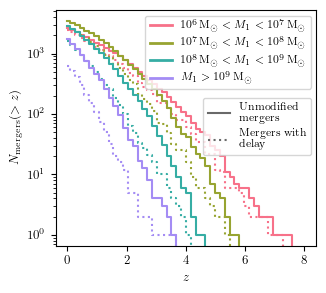

In [30]:
no_delays_6 = []
no_delays_7 = []
no_delays_8 = []
no_delays_9 = []

delays_6 = []
delays_7 = []
delays_8 = []
delays_9 = []

for i, redshift in enumerate(simulation_redshifts):
    m1 = primary_mass[i]
    if m1 >= 1e9:
        no_delays_9.append(redshift)
    elif m1 >= 1e8:
        no_delays_8.append(redshift)
    elif m1 >= 1e7:
        no_delays_7.append(redshift)
    elif m1 >= 1e6:
        no_delays_6.append(redshift)

for i, redshift in enumerate(redshifts_galaxies):
    m1 = primary_mass[i]
    if galaxies_merged[i]:
        if m1 >= 1e9:
            delays_9.append(redshift)
        elif m1 >= 1e8:
            delays_8.append(redshift)
        elif m1 >= 1e7:
            delays_7.append(redshift)
        elif m1 >= 1e6:
            delays_6.append(redshift)

# create redshift bins and then calculate the cumulative number of mergers in each bin (i.e. mergers with z > z_bin)
z_bins = np.linspace(0, 8, 50)
cumulative_no_delays_6 = []
cumulative_no_delays_7 = []
cumulative_no_delays_8 = []
cumulative_no_delays_9 = []

cumulative_delays_6 = []
cumulative_delays_7 = []
cumulative_delays_8 = []
cumulative_delays_9 = []

for z in z_bins:
    cumulative_no_delays_6.append(len([redshift for redshift in no_delays_6 if redshift > z]))
    cumulative_no_delays_7.append(len([redshift for redshift in no_delays_7 if redshift > z]))
    cumulative_no_delays_8.append(len([redshift for redshift in no_delays_8 if redshift > z]))
    cumulative_no_delays_9.append(len([redshift for redshift in no_delays_9 if redshift > z]))

    cumulative_delays_6.append(len([redshift for redshift in delays_6 if redshift > z]))
    cumulative_delays_7.append(len([redshift for redshift in delays_7 if redshift > z]))
    cumulative_delays_8.append(len([redshift for redshift in delays_8 if redshift > z]))
    cumulative_delays_9.append(len([redshift for redshift in delays_9 if redshift > z]))
                               
cumulative_no_delays_6 = np.array(cumulative_no_delays_6)
cumulative_no_delays_7 = np.array(cumulative_no_delays_7)
cumulative_no_delays_8 = np.array(cumulative_no_delays_8)
cumulative_no_delays_9 = np.array(cumulative_no_delays_9)

cumulative_delays_6 = np.array(cumulative_delays_6)
cumulative_delays_7 = np.array(cumulative_delays_7)
cumulative_delays_8 = np.array(cumulative_delays_8)
cumulative_delays_9 = np.array(cumulative_delays_9)

plt.figure(figsize=(10/3, 3))
plt.plot(z_bins, cumulative_no_delays_6, color=colour_map[0], label=r'$10^6 M_\odot < M_1 < 10^7 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins,cumulative_delays_6, color=colour_map[0], linestyle=':', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_no_delays_7, color=colour_map[2], label=r'$10^7 M_\odot < M_1 < 10^8 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_delays_7, color=colour_map[2], linestyle=':', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_no_delays_8, color=colour_map[4], label=r'$10^8 M_\odot < M_1 < 10^9 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_delays_8, color=colour_map[4], linestyle=':', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_no_delays_9, color=colour_map[6], label=r'$M_1 > 10^9 M_\odot$', drawstyle = 'steps-mid')
plt.plot(z_bins, cumulative_delays_9, color=colour_map[6], linestyle=':', drawstyle = 'steps-mid')
from matplotlib.lines import Line2D

# Legend handles for mass bins (colours)
mass_handles = [
    Line2D([0], [0], color=colour_map[0], lw=2, label=r'$10^6 \, \text{M}_\odot < M_1 < 10^7 \, \text{M}_\odot$'),
    Line2D([0], [0], color=colour_map[2], lw=2, label=r'$10^7 \, \text{M}_\odot < M_1 < 10^8 \, \text{M}_\odot$'),
    Line2D([0], [0], color=colour_map[4], lw=2, label=r'$10^8  \, \text{M}_\odot < M_1 < 10^9\, \text{M}_\odot$'),
    Line2D([0], [0], color=colour_map[6], lw=2, label=r'$M_1 > 10^9 \, \text{M}_\odot$'),
]

# Legend handles for models (linestyles)
model_handles = [
    Line2D([0], [0], color='dimgrey', linestyle='-', lw=1.5, label='Unmodified \n mergers'),
    Line2D([0], [0], color='dimgrey', linestyle=':', lw=1.5, label='Mergers with \n delay'),
]

first_legend = plt.legend(
    handles=mass_handles,
    fontsize=8,
    title_fontsize=9,
    loc='upper right',
    bbox_to_anchor=(1.0, 1.0)
)
plt.gca().add_artist(first_legend)

# Second legend: Models (directly under the first)
plt.legend(
    handles=model_handles,
    fontsize=8,
    title_fontsize=9,
    loc='upper right',
    bbox_to_anchor=(1.0, 0.65),
)
plt.yscale('log')
plt.xlabel(r'$z$')
plt.ylabel(r'$N_\text{mergers}(>z)$')
plt.tight_layout()
plt.savefig('../figures/cumulative_mergers_redshift.png', dpi=600)

### BH vs. Host Subhalo Separations

In [15]:
# first need to load the BH separations from the extended merger files
extended_files_path = '/cosma7/data/dp012/dc-butt3/new_merger_events_extended/'

bh_separations = []

for index in indices:
    file_path = os.path.join(extended_files_path, f'{index}.hdf5')
    if os.path.exists(file_path):
        with h5py.File(file_path, 'r') as f:
            header = dict(f['Header'].attrs)
            bh_separation = header['binary_sep']
            bh_separations.append(bh_separation)
    else:
        print(f"File {file_path} does not exist.")

Median separation of galaxies:  68.05263411327265
Median separation of BHs:  1.6555622581719072
Median separation of galaxies (merged):  44.07351883470509


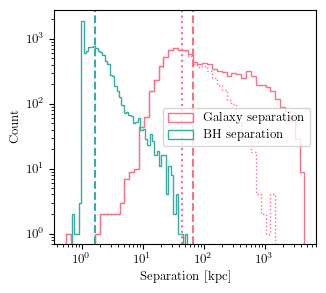

In [22]:
galaxy_separation = np.array(galaxy_separation)
min_sep = np.min(galaxy_separation[galaxy_separation > 0])  # Minimum separation (exclude non-positive values)
max_sep = np.max(galaxy_separation)
bins = np.logspace(np.log10(min_sep), np.log10(max_sep), 50)  # 50 log-spaced bins

# Remove the not merged indices from galaxy_separation
galaxy_separation_merged = np.delete(galaxy_separation, not_merged_indices)

new_bh_separations = np.array(bh_separations)/1000 # converting to kpc
min_bh_sep = np.min(new_bh_separations[new_bh_separations > 0])  # Minimum separation (exclude non-positive values)
max_bh_sep = np.max(new_bh_separations)
bins_bh = np.logspace(np.log10(min_bh_sep), np.log10(max_bh_sep), 50)  # 50 log-spaced bins

# calculate the mean separation in both cases
mean_separation_galaxy = np.median(galaxy_separation)
mean_separation_bh = np.median(new_bh_separations)
mean_separation_galaxy_merged = np.median(galaxy_separation_merged)

print('Median separation of galaxies: ', mean_separation_galaxy)
print('Median separation of BHs: ', mean_separation_bh)
print('Median separation of galaxies (merged): ', mean_separation_galaxy_merged)

plt.figure(figsize=(10/3, 3))
plt.hist(galaxy_separation, bins = bins, histtype='step', label='Galaxy separation', color=colour_map[0])
plt.hist(new_bh_separations, bins=bins_bh, histtype='step', label='BH separation', color=colour_map[4])
plt.hist(galaxy_separation_merged, bins=bins, histtype='step', color=colour_map[0], linestyle=':')
plt.axvline(mean_separation_galaxy, color=colour_map[0], linestyle='--')
plt.axvline(mean_separation_bh, color=colour_map[4], linestyle='--')
plt.axvline(mean_separation_galaxy_merged, color=colour_map[0], linestyle=':')
plt.xlabel('Separation [kpc]')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/host_separation.png', dpi=600)